# Causal Plan

Tooling to create, learn and integrate causality into production planning.

### How to run?

1. Create and activate .venv
    ```
    python3 -m venv .venv
    source .venv/bin/activate
    ```
2. Install requirements via pip
    ```
    pip install -r requirements.txt
    ```
3. Execute this notebook





### 1. Start by call causal network and build three kinds of Production Plan

- causal
- non-causal
- average non causal

In [1]:
from causal.causal_model_causal_non_causal import CausalModelCBN
from causal.causal_model import CausalModel
from plan.GifflerThompson import GifflerThompson
from factory.Operation import Operation
from generators.jobs_data_generator import JobsDataGenerator
from plan.PriorityRules import calculate_dynamic_priority, calculate_fcfs_priority

# Beispielhafte Datenstruktur
# Produkt, Arbeitsgang, Maschinengruppe, Tool, geplante Dauer, Nachfolger
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1]
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]
operations_non_avg_causal = [Operation(*data) for data in jobs_data]

# causal model
observed_data = []

csv_file = 'data/observed_data.csv'
model = CausalModelCBN(csv_file)
#model = CausalModel(csv_file=csv_file)
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    # used for create/modify properties beforehand
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])

    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

def plan_inference_with_avg_duration(operation: Operation, tool) -> int:
    return operation.duration * model.avg_duration

# Case 1: Causal Learned Model
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Case 2: Non-Causal Model
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)

# Case 3: Model with average duration delay
non_avg_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_with_avg_duration)
gt_non_avg_causal_schedule = non_avg_causal.giffen_thompson(operations_non_avg_causal, machine_pools_data)


/home/marvin/repo/PlanCausal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set edges by user
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
Anzahl der erfolgreich gelernten Modelle:  1


###  2. Execute Simulation based on non causal Production Plan


In [2]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

2100
1845
2160
2820
4110
2385
3135
2445
3180
2730
2385
2775
3645
4275
3105
3990
3165
4035
3390
2925
3450
4455
4485
3705
4800
3825
4845
4110
5250
4230
5295
45
45
90
150
3495
360
315
375
555
3585
645
870
735
915
1020
1320
1140
1365
1395
990
1455
1800
3825
1710
1260
1725
2175
3900
1755
2205
1785
2250
1800
2250
1830
2295
1845
1350
1890
2295
3915
1860
1395
1905
2325
3930
1875
1440
1935
2355
3945
1890
1485
1950
2385
3960
1905
2415
1935
2460
1950
1530
1980
2460
3975
1965
1575
1995
2490
3990
1980
2520
2010
2565
2025
1620
2055
2565
4005
2040
1665
2100
2595
4020
2055
1710
2115
2625
4035
2070
1755
2130
2655
4050
2085
1800
2145
2685
4065
2115
2715
2145
2760
2160
1890
2175
2760
4080
2175
1935
2190
2790
4095
2190
2850
2220
2895
2235
1980
2265
2895
4125
2250
2925
2280
2970
2295
2025
2310
2970
4140
2310
2070
2325
3000
4155
2325
2115
2340
3030
4170
2340
3060
2370
3105
2415
2160
2475
3105
4185
2430
2205
2490
3180
4200
2460
3210
2490
3255
2505
2250
2520
3255
4215
2520
2295
2580
3285
4230
2535
3315
2565
3

### 3. Metrics to compare the plan

In [5]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_avg_causal_schedule]), 'NonCausal with AVG')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1568.6 time units
Causal | 1754.5 time units
NonCausal with AVG | 1705.6218235294114 time units
Sim | 1716.28 time units


In [6]:
import math

truth_sim = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])
truth_causal = pd.DataFrame([op.to_dict() for op in gt_causal_schedule])

combined_df = pd.merge(truth_sim, truth_causal, on=['job_id', 'operation_id'], how='outer')

#trouth_sim['diff'] = trouth_sim['duration'] - trouth_sim['plan_duration']
#trouth_causal['diff'] = trouth_causal['plan_duration'] - trouth_causal['duration']
#trouth_sim['sim_causal_dif'] = trouth_causal['plan_duration'] - trouth_sim['duration']


combined_df['diff_sim_truth'] = combined_df['duration_x'] - combined_df['plan_duration_x']
combined_df['diff_causal_truth'] = combined_df['plan_duration_y'] - combined_df['duration_y']
combined_df['diff_causal_sim'] = combined_df['duration_x'] - combined_df['plan_duration_y'] 
combined_df[['duration_x','plan_duration_x', 'diff_sim_truth', 'diff_sim_truth', 'diff_causal_sim']].describe()
# combined_df[combined_df['diff_causal_sim'] > 0].head(1000)



,duration_x,plan_duration_x,diff_sim_truth,diff_sim_truth,diff_causal_sim
count,677.000000,677.000000,677.000000,677.000000,677.000000
mean,27.332349,24.970458,2.361891,2.361891,0.084195
std,13.845525,12.250432,3.073156,3.073156,3.991152
min,15.000000,15.000000,0.000000,0.000000,-9.000000
25%,15.000000,15.000000,0.000000,0.000000,0.000000
50%,18.000000,15.000000,0.000000,0.000000,0.000000
75%,36.000000,30.000000,3.000000,3.000000,3.000000
max,54.000000,45.000000,9.000000,9.000000,9.000000


### 4. Save the observed data for causal learning (required for step causal plan)

In [7]:
df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'delay'])
df_observed_data.to_csv(csv_file)

### 5. Evaulation

#### 5.1 Simulation (with predefiend model)

/tmp/ipykernel_406989/1685830134.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


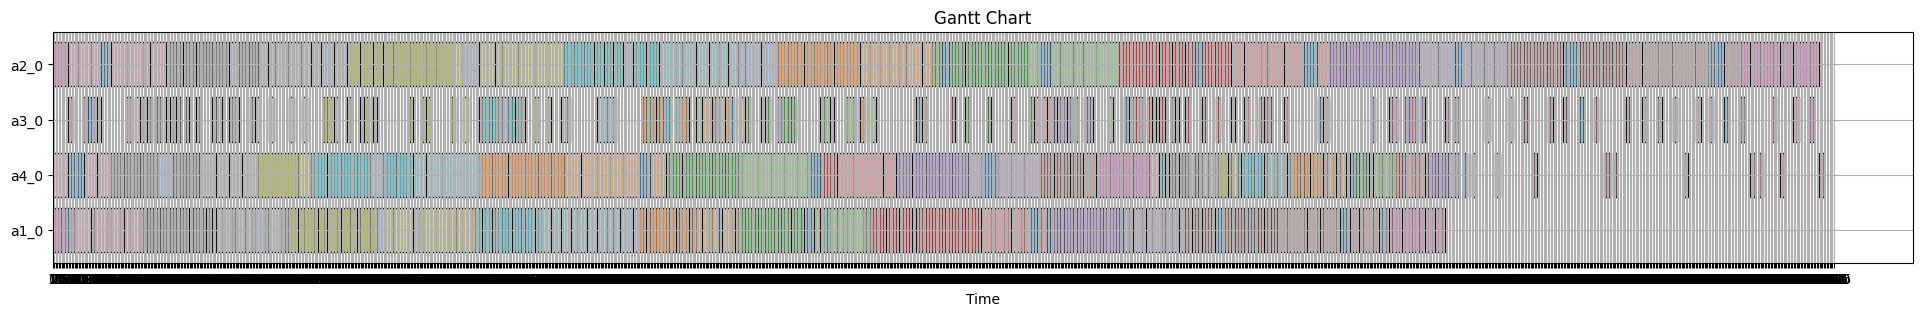

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen (optional, falls du das möchtest)
    # ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))

# Grid anzeigen
ax.grid(True)

# Diagramm anzeigen
plt.show()

#### 5.2 Plan without causal model

/tmp/ipykernel_345271/1553617269.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


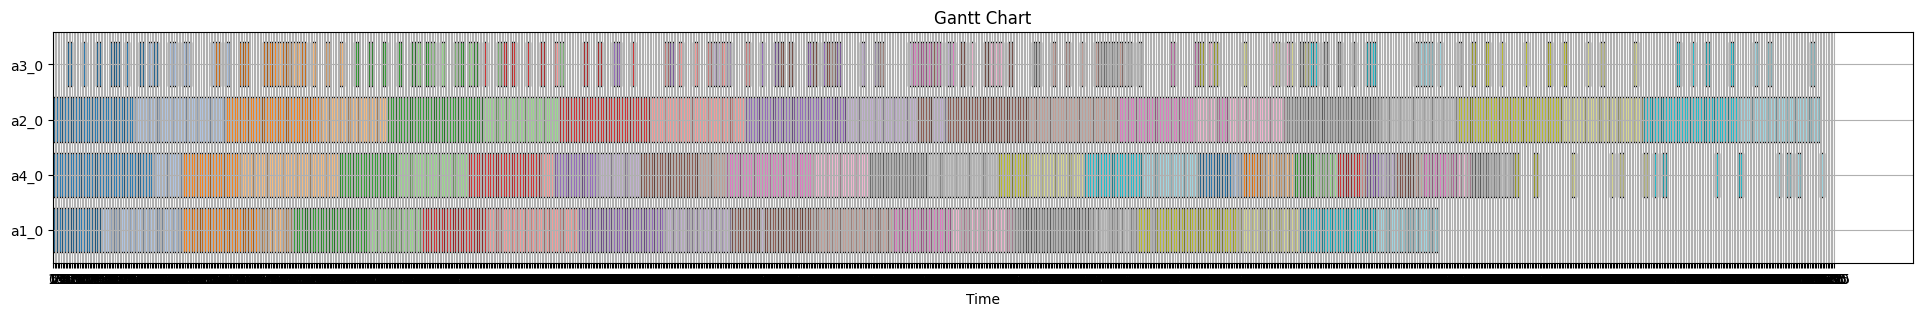

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_non_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


#### 5.3 Plan with causal model

/tmp/ipykernel_345271/873938610.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


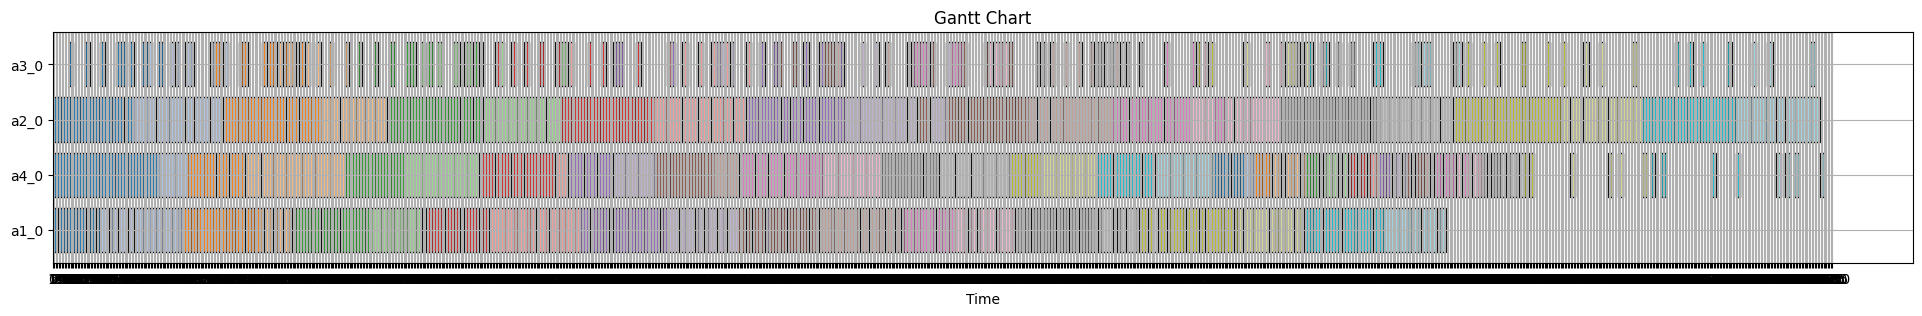

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]
    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)


# Diagramm anzeigen
plt.show()
